# 💥 Includes

This Kaggle kernel will document my primary exploits for this competition. Here I am trying to train an simple multi-label image classifier. The idea is to experiment few techniques before leveraging weak supervision for instance segmentation.

Key features:

* Simple to follow along code. 
* Binary crossentropy as loss function. `AUC` as metric.
* Early stopping regularization monitoring `val_auc`.
* Using EfficientNetB0 with input image size 256x256. 

Updates:

* Using Focal Loss.

Here are some of my other kernels. 

* [RGB 512x512 Dataset Creation+Versioning with W&B](https://www.kaggle.com/ayuraj/hpa512x512dataset)
    * I used this kernel to build RGB dataset of size 512x512 pixels. I am leaving out the yellow channel for now. My input data pipeline initially took approx 50 minutes per epoch when I was loading images(channels) separately and then stacking them. By using an already stacked image the ETA per epoch is approx 3 mins. 
    * I am also using Weights and Biases(W&B) in this kernel to store train-validation split as artifacts. 

* [HPA: Segmentation Mask Visualization with W&B](https://www.kaggle.com/ayuraj/hpa-segmentation-mask-visualization-with-w-b)
    * In this kernel I am attempting to understand the use of HPA Cell Segmentation tool provided by the competition hosts. 
    * I am also using W&B's interactive visualization to play with the segmentation masks that are logged. 
    * Here's a short report summarizing the result: http://bit.ly/play-with-segmentation-masks
    
    
**If you like the work, upvote for encouragement. Let's discuss ideas in the comment section.** 


# 🧰 Setups, Installations and Imports

In [ ]:
%%capture
# Install Weights and Biases.
!pip install wandb -q

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

import os
import re
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt

%matplotlib inline

# Imports for augmentations. 
from albumentations import (
    Compose, RandomCrop, RandomResizedCrop, HorizontalFlip, VerticalFlip, Resize 
)

We will use Weights and Biases for experiment tracking.

In [ ]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

wandb.login(key=wandb_api)

In [ ]:
# Set the random seeds
def seed_everything():
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)
    
seed_everything()

# 📀 Set Hyperparameters

In [ ]:
WORKING_DIR_PATH = '../input/hpa-single-cell-image-classification/'

# RGB images of size 256x256.
TRAIN_512 = '../input/hpa256x256dataset/train/rgb/'

IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Prepare `tf.data` Dataloader

In [ ]:
df_train = pd.read_csv(WORKING_DIR_PATH+'train.csv')
df_train.head()

The `train.csv` holds ID for the training images and image-level labels. **There are a total of 21,806 training images.**

### Get Train-Val Split from saved W&B Artifact

In [ ]:
run = wandb.init(project='hpa', job_type='consume_split')
artifact = run.use_artifact('ayush-thakur/hpa/split:v0', type='dataset')
SPLIT_CSV_PATH = artifact.download()
run.finish()

In [ ]:
df_train_split = pd.read_csv(SPLIT_CSV_PATH+'/train_split.csv')
df_val_split = pd.read_csv(SPLIT_CSV_PATH+'/val_split.csv')

print(df_train_split.head(), '\n', df_val_split.head())

In [ ]:
# Ref: https://www.kaggle.com/divyanshuusingh/eda-image-segmentation
LABELS= {
0: "Nucleoplasm",
1: "Nuclear membrane",
2: "Nucleoli",
3: "Nucleoli fibrillar center",
4: "Nuclear speckles",
5: "Nuclear bodies",
6: "Endoplasmic reticulum",
7: "Golgi apparatus",
8: "Intermediate filaments",
9: "Actin filaments",
10: "Microtubules",
11: "Mitotic spindle",
12: "Centrosome",
13: "Plasma membrane",
14: "Mitochondria",
15: "Aggresome",
16: "Cytosol",
17: "Vesicles and punctate cytosolic patterns",
18: "Negative"
}

In [ ]:
# Ref: https://github.com/tensorflow/tensorflow/issues/16044
@tf.function
def multiple_one_hot(cat_tensor, depth_list):
    """Creates one-hot-encodings for multiple categorical attributes and
    concatenates the resulting encodings

    Args:
        cat_tensor (tf.Tensor): tensor with mutiple columns containing categorical features
        depth_list (list): list of the no. of values (depth) for each categorical

    Returns:
        one_hot_enc_tensor (tf.Tensor): concatenated one-hot-encodings of cat_tensor
    """
    one_hot_enc_tensor = tf.one_hot(cat_int_tensor[:,0], depth_list[0], axis=1)
    for col in range(1, len(depth_list)):
        add = tf.one_hot(cat_int_tensor[:,col], depth_list[col], axis=1)
        one_hot_enc_tensor = tf.concat([one_hot_enc_tensor, add], axis=1)

    return one_hot_enc_tensor

@tf.function
def decode_image(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Normalize image
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    # resize the image to the desired size
    return img

def resize_val_image(image, label):
    return tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]), label

@tf.function
def load_image(df_dict):
    # Load image
    image = tf.io.read_file(TRAIN_512+df_dict['ID']+'.png')
    image = decode_image(image)
    
    # Parse label
    label = tf.strings.split(df_dict['Label'], sep='|')
    label = tf.strings.to_number(label, out_type=tf.int32)
    label = tf.reduce_sum(tf.one_hot(indices=label, depth=19), axis=0)
    
    return image, label

### Augmentation using Albumentations

In [ ]:
# Define the augmentation policies. Note that they are applied sequentially with some probability p.
transforms = Compose([
                RandomResizedCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),
                HorizontalFlip(),
                VerticalFlip()
        ])

# Apply augmentation policies.
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]

    return aug_img

In [ ]:
@tf.function
def apply_augmentation(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    
    return aug_img, label

In [ ]:
# Consume training CSV 
train_ds = tf.data.Dataset.from_tensor_slices(dict(df_train_split))
val_ds = tf.data.Dataset.from_tensor_slices(dict(df_val_split))

# Training Dataset
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Validation Dataset
val_ds = (
    val_ds
    .shuffle(1024)
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(resize_val_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Visualize Batch

In [ ]:
def get_label_name(labels):
    l = np.where(labels == 1.)[0]
    label_names = []
    for label in l:
        label_names.append(LABELS[label])
        
    return '-'.join(str(label_name) for label_name in label_names)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(get_label_name(label_batch[n].numpy()))
      plt.axis('off')

In [ ]:
# Training batch
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

In [ ]:
# Validation batch
image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch, label_batch)

# 🐤 Model

In [ ]:
def get_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
    base_model.trainabe = True

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(LABELS), activation='sigmoid')(x)
    
    return Model(inputs, outputs)

tf.keras.backend.clear_session()
model = get_model()
model.summary()

# 📲 Callbacks

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='min',
    restore_best_weights=True
)

lronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

# 🚋 Train with W&B

In [ ]:
# Initialize model
tf.keras.backend.clear_session()
model = get_model()

# Compile model
model.compile('adam', 
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[tf.keras.metrics.AUC(multi_label=True)])

# Initialize W&B run
run = wandb.init(entity='ayush-thakur', project='hpa', job_type='train')

# Train
model.fit(train_ds, 
          epochs=50,
          validation_data=val_ds,
          callbacks=[WandbCallback(),
                     earlystopper])

# Close W&B run
run.finish()

In [ ]:
model.evaluate(val_ds)

# Save Model as Artifacts

In [ ]:
model.save('effnet_multilabel_1.h5')

In [ ]:
run = wandb.init(project='hpa', job_type='model')
artifact = run.use_artifact('ayush-thakur/hpa/split:v0', type='dataset')

artifact_model = wandb.Artifact('multi-label-model', type='model')

# Add a file to the artifact's contents
artifact_model.add_file('effnet_multilabel_1.h5')

# Save the artifact version to W&B and mark it as the output of this run
run.log_artifact(artifact_model)

run.finish()

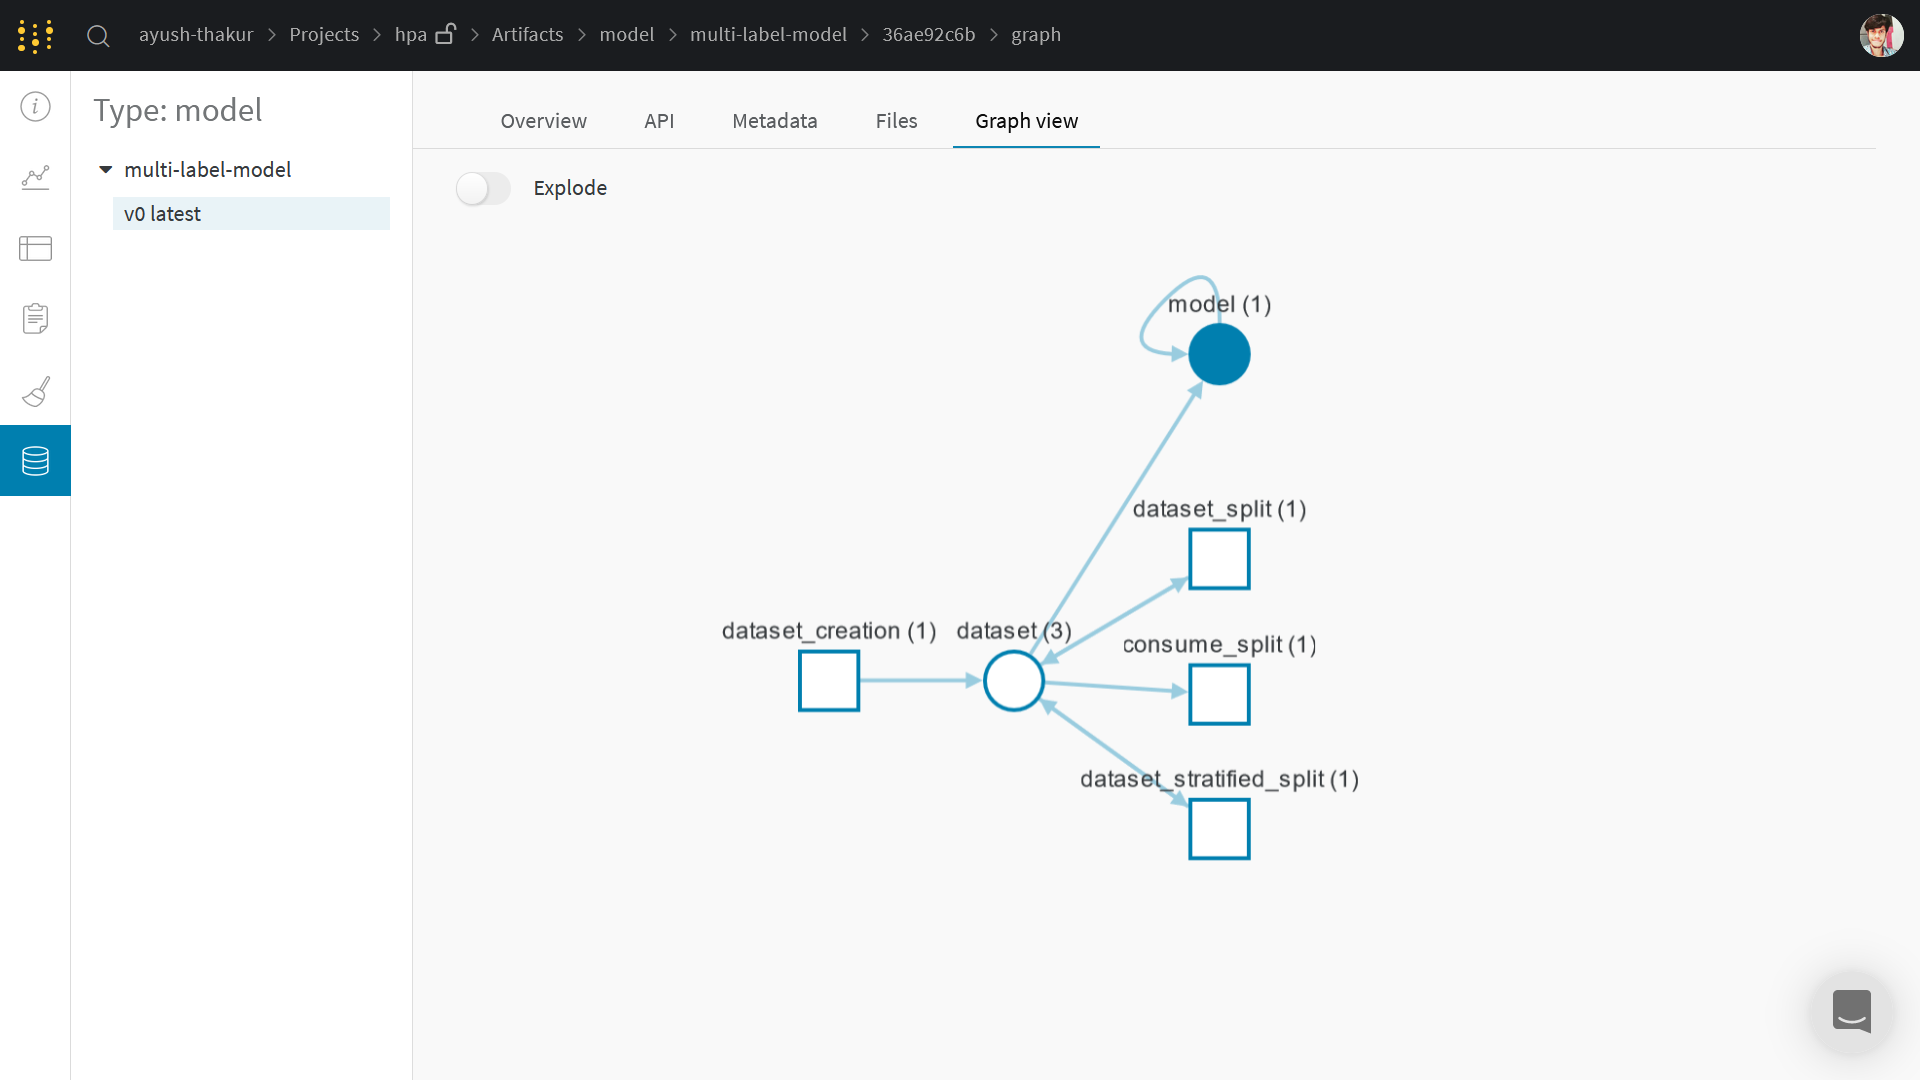

# Work In Progress -> Stay Tuned. 